In [32]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [33]:
stock_name = 'AMZN'

In [34]:
all_tweets = pd.read_csv('stock_tweets.csv')

In [35]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [36]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc."
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc."
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc."
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc."
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc."


In [37]:
sent_df = df.copy()
sent_df["Sentiment Score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment Score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",,,,


In [38]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
        
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
                                           
        sent_df.at[indx, 'Sentiment Score'] = sentence_sentiment['compound']
                                           
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
                                    
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
                                           
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
                                           
    except TypeError:
                print(sent_df.loc[indx, 'Tweet'])
                print(indx)
                                           
                break

CPU times: total: 4.14 s
Wall time: 4.18 s


In [39]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment Score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",-0.0772,0.084,0.841,0.075
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",0.25,0.158,0.684,0.158
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",-0.3182,0.164,0.728,0.108
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",0.2382,0.065,0.851,0.083
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",0.7783,0.0,0.799,0.201


In [40]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [41]:
sent_df.head()

,Date,Tweet,Sentiment Score
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,-0.0772
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,-0.3182
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,0.2382
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,0.7783


In [42]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()
print(twitter_df.shape)

(365, 1)


In [43]:
twitter_df.head()

,Sentiment Score
Date,
2021-09-30,0.246480
2021-10-01,0.359338
2021-10-02,-0.000700
2021-10-03,0.834400
2021-10-04,0.258650


In [44]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [45]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [46]:
final_df = stock_df.join(twitter_df, how='left', on='Date')
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [47]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.246480
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359338
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.258650
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.045500
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.194300


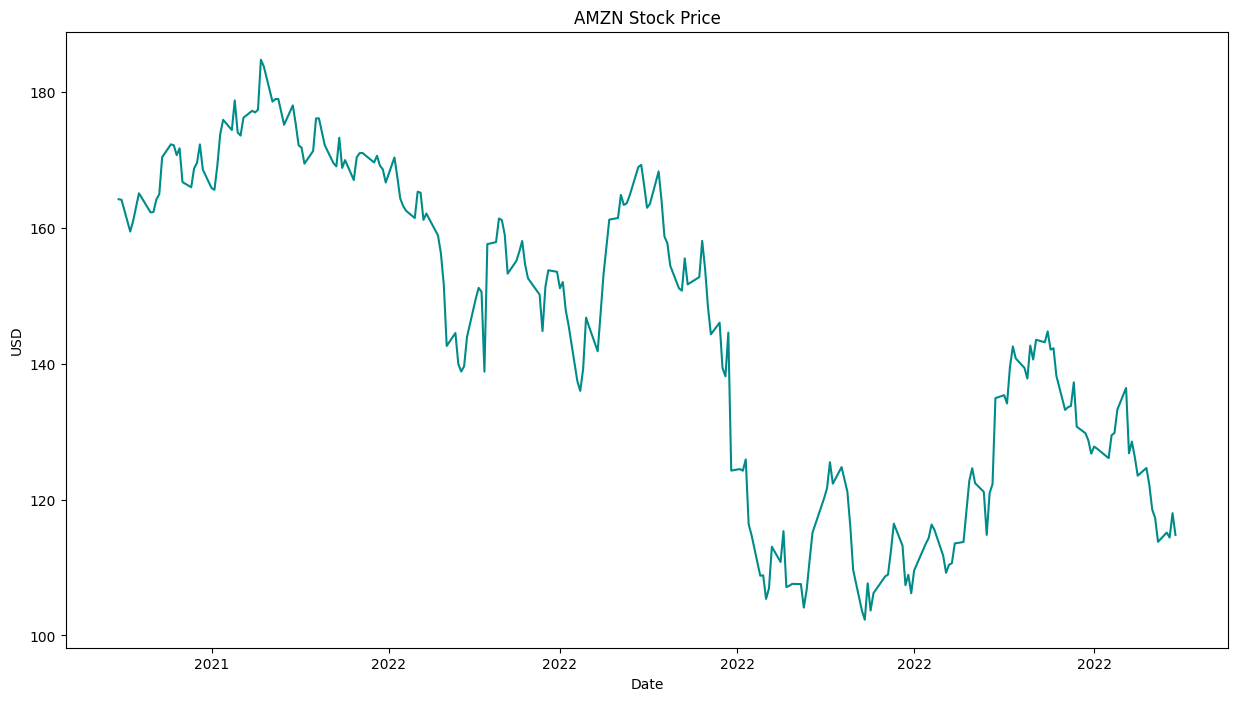

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel = "Date", ylabel = "USD", title = f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [49]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()

    data['MA20'] = data.iloc[:,4].rolling(window=20).mean()

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12, adjust=False).mean()

    data['20SD'] = data.iloc[:,4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    data['EMA'] = data.iloc[:,4].ewm(com = 0.5).mean()

    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data


In [50]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


In [51]:
def tech_ind(dataset):
    fig, ax = plt.subplots(figsize = (15,8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label = 'Moving Average (7 Days)', color = 'g', linestyle = '--')
    ax.plot(dataset['Date'], dataset['Close'], label = 'Closing Price', color = '#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label = 'Moving Average (20 Days)', color = 'r', linestyle = '--')

    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical Indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel('Year')

    plt.legend()

    plt.show()

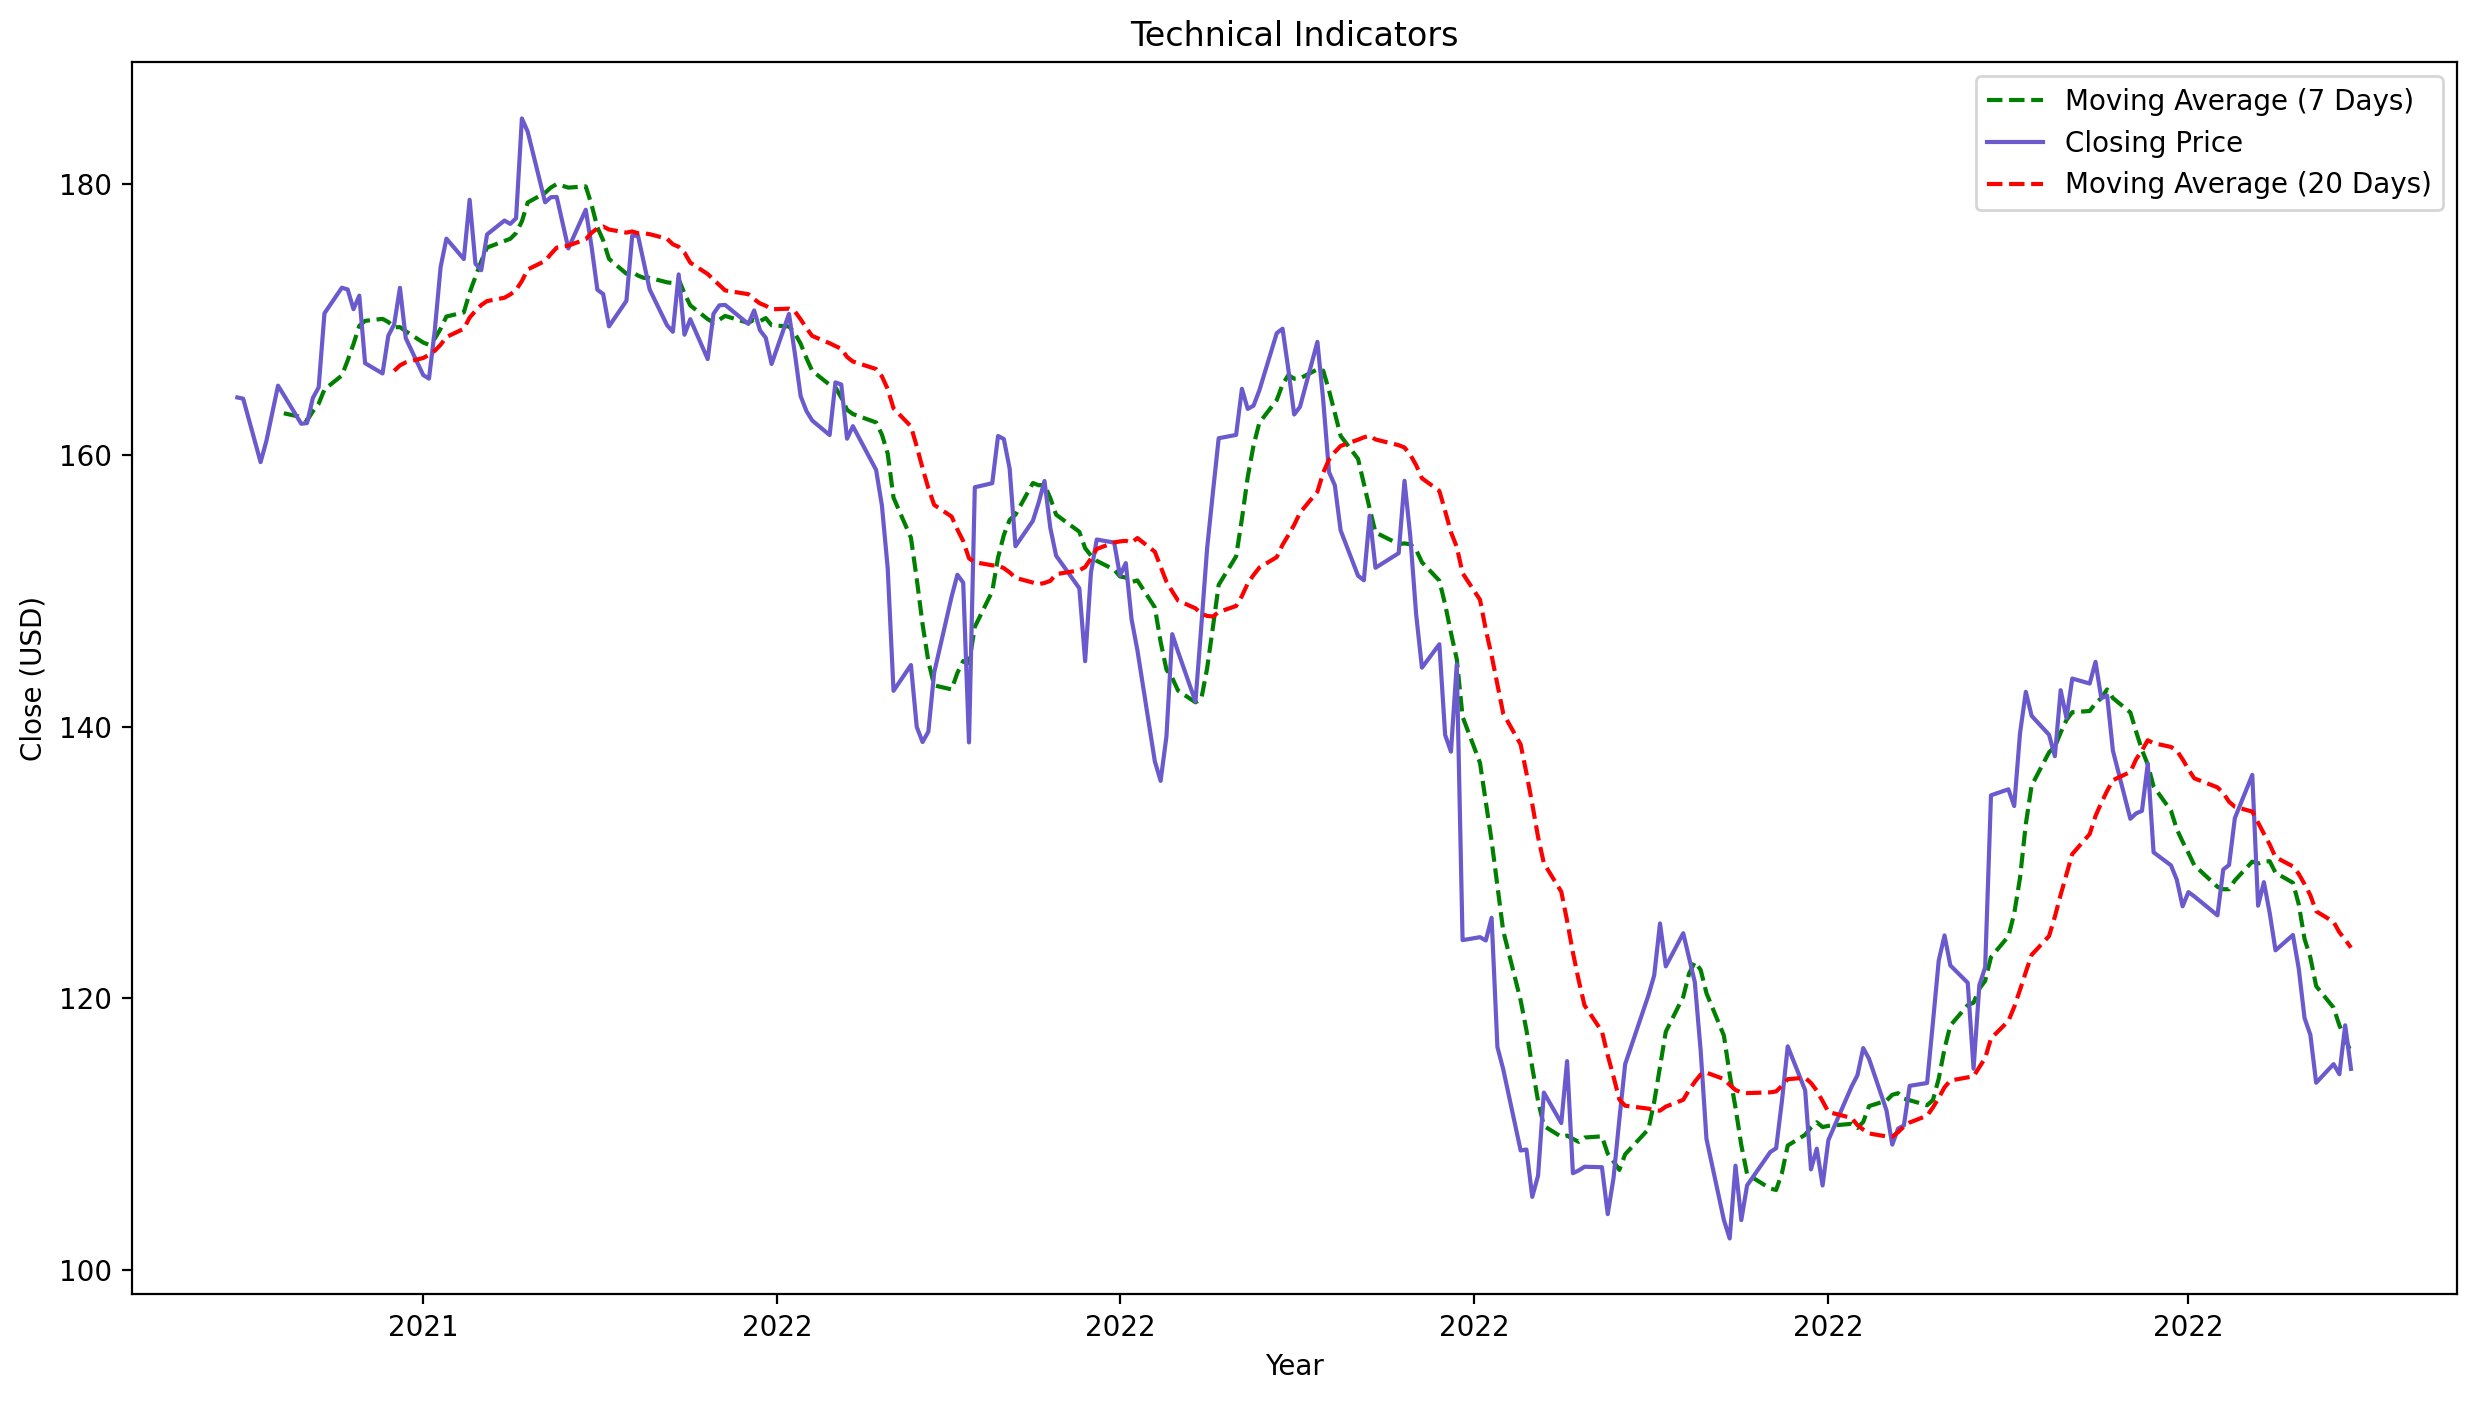

In [52]:
tech_ind(tech_df)

In [53]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:,1:].ffill()])

In [54]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


In [55]:
dataset.rename(columns={' ': 'Date'}, inplace=True)

In [56]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


In [85]:
dataset['Date']= dataset['Date'].astype(str)
dataset['Date'] = dataset['Date'].str.replace('-', '')

In [87]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,20211028,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,20211029,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,20211101,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,20211102,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,20211103,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


In [67]:
def normalize_data(df, range, target_column):
    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset, y_scale_dataset)

In [68]:
def batch_data(x_data, y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0, len(x_data), 1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]

        if len(x_value) == batch_size and len(y_value == predict_period):
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [69]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [70]:
def predict_index(dataset, X_train, batch_size, prediction_period):
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index

    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:,:].index

    return train_predict_index, test_predict_index

In [88]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 16)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [89]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]


In [90]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences= True, input_shape = (input_dim, feature_size),recurrent_dropout=0.3),
                                 LSTM(units = 512, return_sequences= True,recurrent_dropout=0.3),
                                 LSTM(units = 256, return_sequences= True,recurrent_dropout=0.3),
                                 LSTM(units = 128, return_sequences= True,recurrent_dropout=0.3),
                                 LSTM(units = 64,recurrent_dropout=0.3),
                                 Dense(32),
                                 Dense(16),
                                 Dense(8),
                                 Dense(units=output_dim)])
    
    return model

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8,input_shape=(input_dim+1, 1), kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size = 3, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size = 1, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.01)))